<a href="https://colab.research.google.com/github/juanPellegrini11/Redes_neuronales_FashionMNIST/blob/main/Redes_neuronales_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 4 - Redes neuronales

Grupo 35:

    Juan Pellegrini       C.I.: 4.814.284-2
    Emiliano Hernández    C.I.: 4.660.612-3


##Problema
Considere Fashion-MNIST1
, un conjunto de datos con imágenes de 10 tipos diferentes de
artículos de la empresa de vestimenta Zalando, con 60.000 instancias de entrenamiento y 10.000
de evaluación. Cada imagen en escala de gris del dataset tiene un tamaño de 28x28 píxeles y
asociada a cada una existe una etiqueta entera en el rango 0-10, representando cada categoría.

###a) Construya un clasificador base:

####i) Defina un red neuronal feedforward base con una capa oculta de 32 unidades y que utilice la función sigmoide como activación, que devuelva, para una imagen de entrada, una distribución de probabilidad sobre las categorías, y permita asignarle la categoría más probable.

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Se importan los datos de MNIST
image_path = './'

# Esto nos permite convertir las features de los píxeles en tensores y los normaliza al rango [0,1]
transform = transforms.Compose([transforms.ToTensor()])

# Importamos los datasets
# Las etiquetas corresponden a 10 prendas de vestir (pantalón, zapato, sandalia, bolso, etc.). El dataset tiene 60k imágenes de entrenamiento y 10k de validación
fashionmnist_train_dataset = torchvision.datasets.FashionMNIST(root=image_path, train=True, transform=transform, download=True)
fashionmnist_test_dataset  = torchvision.datasets.FashionMNIST(root=image_path, train=False, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 17534320.92it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 343226.36it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6156598.69it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5103350.74it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
# Se divide el conjunto de entrenamiento en conjuntos de entrenamiento y validación
fashionmnist_train, fashionmnist_val = train_test_split(fashionmnist_train_dataset, test_size=0.2, random_state=42)

# Se imprime el tamaño de cada conjunto para observar que esté bien distribuido
print('Tamaño del conjunto de entrenamiento: ', len(fashionmnist_train))
print('Tamaño del conjunto de validación: ', len(fashionmnist_val))
print('Tamaño del conjunto de testeo: ', len(fashionmnist_test_dataset))

Tamaño del conjunto de entrenamiento:  48000
Tamaño del conjunto de validación:  12000
Tamaño del conjunto de testeo:  10000


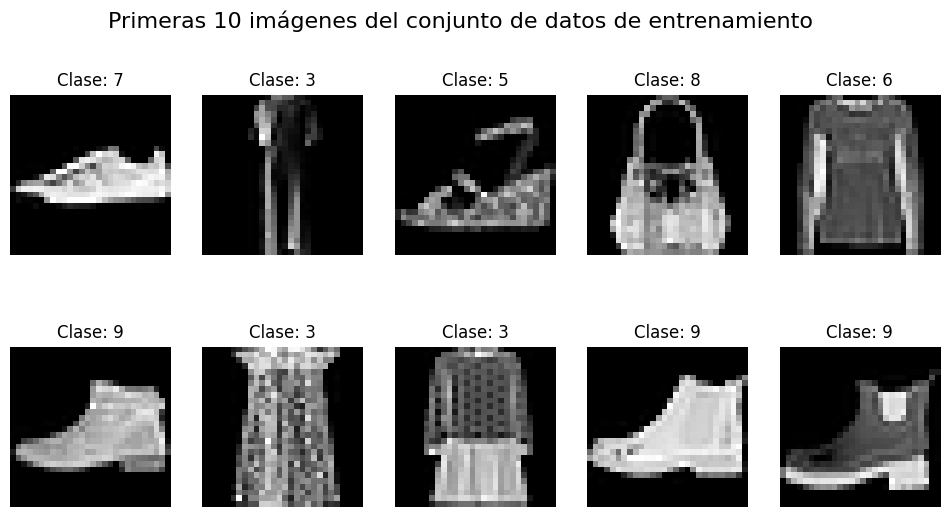

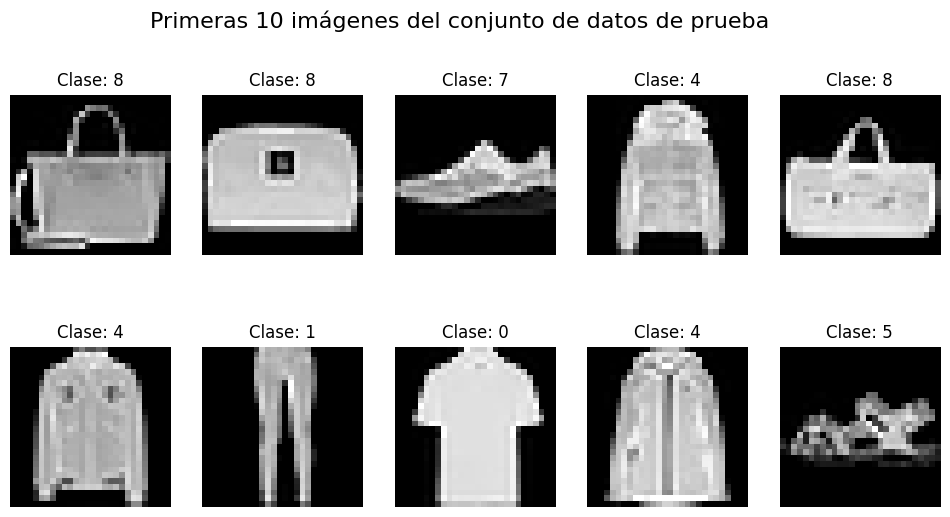

In [ ]:
# Vemos las primeras 10 imágenes de cada dataset
def primeras10instancias(dataset, train_test):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(f"Primeras 10 imágenes del conjunto de datos {train_test}", fontsize=16)
    for i in range(10):
        image, label = dataset[i]
        ax = axes[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Clase: {label}')
        ax.axis('off')
    plt.show()

primeras10instancias(fashionmnist_train, "de entrenamiento")
primeras10instancias(fashionmnist_val, "de prueba")

In [ ]:
# Utilizamos DataLoader para construir un iterable con batch_size = 64 (cada lote tiene 64 instancias)
batch_size = 64
torch.manual_seed(10)
train_dl = DataLoader(fashionmnist_train, batch_size, shuffle=True)
val_dl = DataLoader(fashionmnist_val, batch_size, shuffle=True)

In [ ]:
cantidad_categorias = 10
image_size = fashionmnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

# Se crea el modelo base
hidden_units = 32

# Nuestro primer paso es convertir las imágenes a un vector
all_layers = [nn.Flatten()]

# Creamos la capa oculta
layer = nn.Linear(input_size, hidden_units)
all_layers.append(layer)

# Agregamos la función de activación sigmoide
all_layers.append(nn.Sigmoid())

# Agregamos la capa de salida
all_layers.append(nn.Linear(hidden_units,cantidad_categorias))

# Construimos el modelo
model = nn.Sequential(*all_layers)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=32, out_features=10, bias=True)
)


####ii) Utilizando el conjunto de entrenamiento provisto, entrene a la red construida en el paso anterior durante 10 épocas, utilizando descenso por gradiente estocástico y una tasa de aprendizaje de 0.01

In [ ]:
# Se crea función de entrenamiento que luego se va a utilizar en las partes siguientes
def train(model, num_epochs, optimizer):

  loss_fn = nn.CrossEntropyLoss()
  torch.manual_seed(10)

  # Inicializar listas para almacenar la pérdida y la precisión
  lista_perdida = []
  lista_accuracy = []

  for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:

      # Paso forward, obtenemos la predicción de la red con los valores actuales
      pred = model(x_batch)

      # Calculamos la pérdida.
      loss = loss_fn(pred,y_batch)

      # Backpropagation!
      loss.backward()

      # Guardamos la pérdida de cada iteración
      lista_perdida.append(loss.item())

      # Ajustamos los pesos utilizando el algoritmo de optimización
      optimizer.step()
      optimizer.zero_grad()

      is_correct = (torch.argmax(pred,dim=1) == y_batch).float()

      accuracy_hist_train += is_correct.sum()

    accuracy_hist_train /= len(train_dl.dataset)

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        lista_accuracy.append(correct / total)
    accuracy_val = 0

    # Guardamos el accuracy  de cada iteración
    # lista_accuracy.append(accuracy_val)
    print(f'Epoch {epoch}  Accuracy del conjunto de entrenamiento ' f'{accuracy_hist_train:.4f}')

  return model, lista_perdida, lista_accuracy

In [ ]:
# Realizamos el entrenamiento del modelo base
tasa_aprendizaje = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=tasa_aprendizaje)
num_epochs = 10
model, lista_perdida, lista_accuracy = train(model, num_epochs, optimizer)

Epoch 0  Accuracy del conjunto de entrenamiento 0.4407
Epoch 1  Accuracy del conjunto de entrenamiento 0.5954
Epoch 2  Accuracy del conjunto de entrenamiento 0.6391
Epoch 3  Accuracy del conjunto de entrenamiento 0.6778
Epoch 4  Accuracy del conjunto de entrenamiento 0.7109
Epoch 5  Accuracy del conjunto de entrenamiento 0.7287
Epoch 6  Accuracy del conjunto de entrenamiento 0.7425
Epoch 7  Accuracy del conjunto de entrenamiento 0.7525
Epoch 8  Accuracy del conjunto de entrenamiento 0.7593
Epoch 9  Accuracy del conjunto de entrenamiento 0.7662


####iii) Evalúe el rendimiento del clasificador construido sobre un conjunto de validación.

A continuación se procede a evaluar el modelo sobre el conjunto de validación. Como pudo verse en la parte anterior, el modelo fue mejorando el porcentaje de aciertos en la predicción con cada época de entrenamiento, logrando obtener hasta un 76,6% de predicciones exitosas, valor similar al que se obtiene al evaluar el modelo en el conjunto de datos de validación (lo que implica que el modelo no se sobreajusto con las 10 épocas de entrenamiento):

In [ ]:
accuracy_val = 0
for x_val, y_val in val_dl:
  pred_val = model(x_val)
  is_correct = (torch.argmax(pred_val,dim=1) == y_val).float()
  accuracy_val += is_correct.sum()
accuracy_val /= len(val_dl.dataset)
print(f'Test de accuracy para el conjunto de validación {accuracy_val:.4f}')

Test de accuracy para el conjunto de validación 0.7654


####iv) Reporte gráficamente la evolución de la pérdida en el conjunto de entrenamiento y de la accuracy sobre el conjunto de validación en función de las iteraciones

In [ ]:
# Se crea función para graficar evolución de pérdida y accuracy
def graficar_evolucion_perdida_acurracy(lista_loss, lista_accuracy):

  # Graficar la pérdida y la precisión
  plt.figure(figsize=(12, 5))

  # Graficar la pérdida en el conjunto de entrenamiento
  plt.subplot(1, 2, 1)
  plt.plot(lista_loss, label='Pérdida')
  plt.xlabel('Proceso')
  plt.ylabel('Pérdida')
  plt.title('Evolución de la pérdida')
  plt.legend()

  # Graficar la precisión en el conjunto de validación
  plt.subplot(1, 2, 2)
  plt.plot(lista_accuracy, label='Accuracy', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Evolución del accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

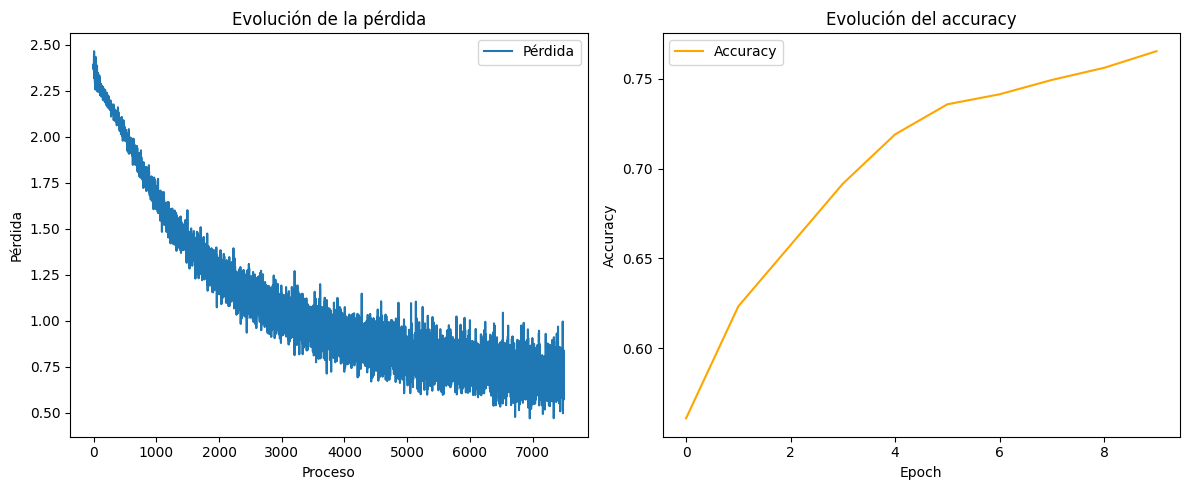

In [ ]:
# Graficamos utilizando los datos obtenidos del entrenamiento
graficar_evolucion_perdida_acurracy(lista_perdida, lista_accuracy)

###b) Proponga tres arquitecturas adicionales que busquen mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, y/o diferentes funciones de activación. Para cada una, evalúe su rendimiento sobre un conjunto de validación, con diferentes valores de tasa de aprendizaje.

####Arquitectura 1

#####Definición y entrenamiento

In [ ]:
#   Modelo A: distinta función de activación
modela = nn.Sequential(
    nn.Flatten(),           # Aplananamos la entrada
    nn.Linear(28*28, 32),   # Dejamos la misma capa oculta que en el modelo base
    nn.ReLU(),              # Cambiamos sigmoide por función de activación ReLU
    nn.Linear(32, 10))      # Capa de salida

#   Modelo B: agregamos otra capa oculta
#Agregamos capa oculta aumentando número de unidades totales
modelbi = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),      # Capa oculta con 32 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(32, 32),         # Otra capa oculta con 32 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(32, 10))
#Agregamos capa oculta manteniendo número de unidades totales
modelbii = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 16),      # Capa oculta con 16 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(16, 16),         # Otra capa oculta con 16 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(16, 10))
#Agregamos capa oculta bajando número de unidades totales
modelbiii = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 8),       # Capa oculta con 8 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(8, 8),           # Otra capa oculta con 8 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(8, 10))

#   Modelo C: modificamos número total de unidades
#Aumentamos número de unidades totales
modelci = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 48),      # Capa oculta con 48 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(48, 10))
#Bajamos número de unidades totales
modelcii = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 16),      # Capa oculta con 16 unidades
    nn.Sigmoid(),              # Función de activación sigmoide
    nn.Linear(16, 10))

#Vemos como queda cada grupo de modelos definidos
print(modela)
print(modelbi)
print(modelci)


#     Entrenamos Modelos
#Defino función
def train2(model,LR):
  optimizer = torch.optim.SGD(model.parameters(), lr=LR)
  optimizer.zero_grad()  # Restablecer gradientes a cero cada vez que llamo la función
  num_epochs = 10
  modele, lista_perdida, lista_accuracy = train(model, num_epochs, optimizer)

  accuracy_val = 0
  for x_val, y_val in val_dl:
    pred_val = modele(x_val)
    is_correct = (torch.argmax(pred_val,dim=1) == y_val).float()
    accuracy_val += is_correct.sum()
  accuracy_val /= len(val_dl.dataset)
  print(f'Test de accuracy para el conjunto de validación {accuracy_val:.4f}')

#Hacemos lista con modelos para el entrenamiento
models = [modela, modelbi, modelbii, modelbiii, modelci, modelcii]
#Hacemos lista con LR
LRs = [0.005, 0.01, 0.015, 0.05]

for Lr in LRs:
  for mod in models:
    train2(mod, Lr)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=32, out_features=10, bias=True)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=48, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=48, out_features=10, bias=True)
)
Epoch 0  Accuracy del conjunto de entrenamiento 0.5281
Epoch 1  Accuracy del conjunto de entrenamiento 0.6943
Epoch 2  Accuracy del conjunto de entrenamiento 0.7433
Epoch 3  Accuracy del conjunto de entrenamiento 0.7704
Epoch 4  Accuracy del conjunto de entrenamiento 0.7887
Epoch 5  Accuracy del conjunto de entrenamiento 0.8007
Epoch 6  Accuracy del conjunto de 

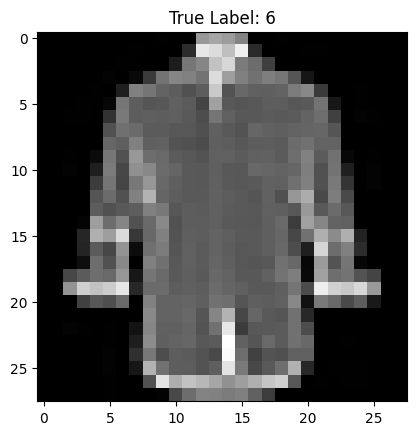

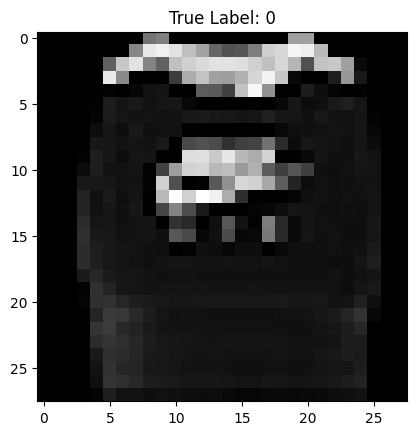

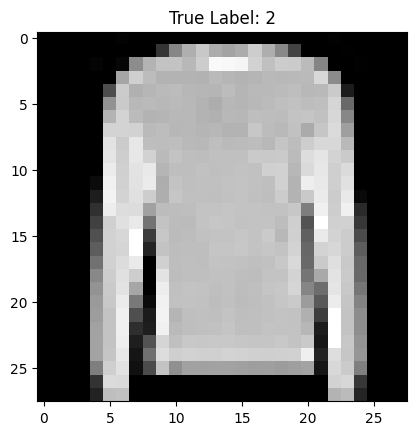

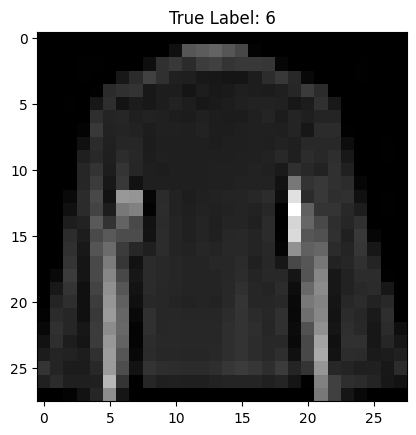

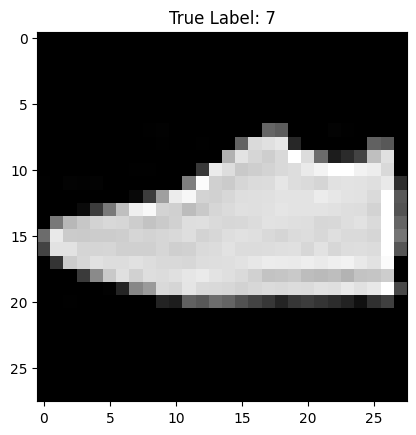

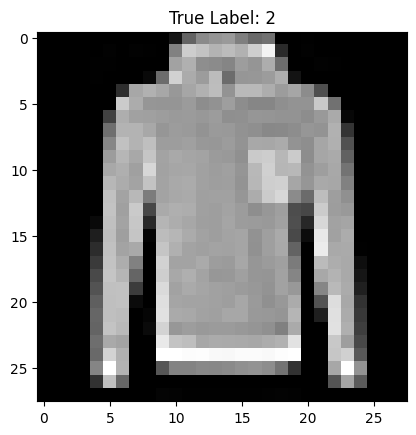

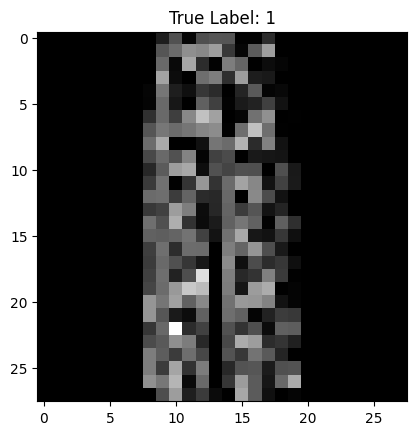

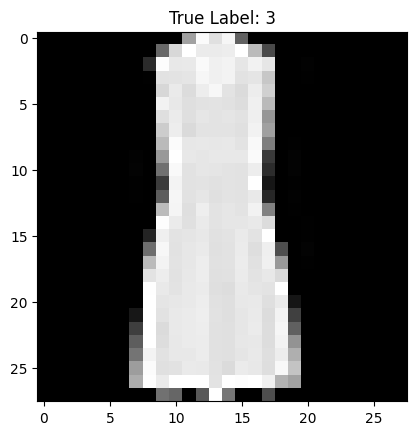

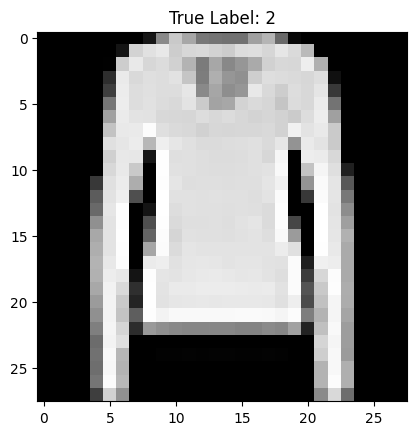

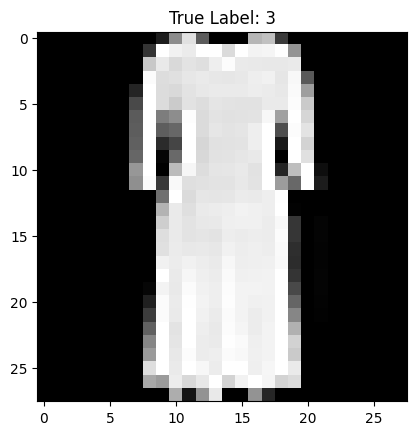

In [ ]:
import torch.nn.functional as F

def calculate_entropy(predictions):
    return -torch.sum(F.log_softmax(predictions, dim=1) * predictions, dim=1)

#Evaluamos en el conjunto de testeo (seguramente se hará en la parte c o d)
test_dl = DataLoader(fashionmnist_test_dataset, batch_size, shuffle=True)

# Evaluar el modelo en el conjunto de prueba
model.eval()  # Cambiar el modelo al modo de evaluación
predictions = []  # Almacena las predicciones del modelo
true_labels = []  # Almacena las etiquetas reales

for images, labels in test_dl:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(outputs.tolist())
    true_labels.extend(labels.tolist())

# Calcula las entropías de las predicciones
entropies = calculate_entropy(torch.tensor(predictions))

# Encuentra los índices de las 10 instancias más difíciles de clasificar
top_difficult_indices = entropies.argsort(descending=True)[:10]

# Muestra las imágenes y sus etiquetas correspondientes
for index in top_difficult_indices:
    image, true_label = fashionmnist_test_dataset[index]
    plt.imshow(image[0], cmap='gray')
    plt.title(f'True Label: {true_label}')
    plt.show()

# Muestra las imágenes y sus etiquetas correspondientes
#for index in top_difficult_indices:
#    image, true_label, predicted_label = fashionmnist_test_dataset[index]
#    plt.imshow(image[0], cmap='gray')
#    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
#    plt.show()

In [ ]:
print(top_difficult_indices)

tensor([4287, 3827, 8645, 8487,  104, 2953, 4374, 2539, 4900, 6367])


In [ ]:
#Evaluamos en el conjunto de testeo (seguramente se hará en la parte c o d)
test_dl = DataLoader(fashionmnist_test_dataset, batch_size, shuffle=True)

# Función para calcular la entropía de una predicción
def entropy(predictions):
    return -torch.sum(predictions * torch.log(predictions), dim=1)

# Evaluar el modelo en el conjunto de prueba
model.eval()  # Cambiar el modelo al modo de evaluación
predictions = []  # Almacena las predicciones del modelo
true_labels = []  # Almacena las etiquetas reales

with torch.no_grad():
    for images, labels in test_dl:
        outputs = model(images)
        predictions.extend(torch.softmax(outputs, dim=1).tolist())  # Almacena las predicciones
        true_labels.extend(labels.tolist())  # Almacena las etiquetas reales

# Calcular la entropía para cada predicción
entropies = [entropy(torch.tensor(pred)) for pred in predictions]

# Clasificar las instancias según la entropía en orden descendente
top_difficult_instances = sorted(range(len(entropies)), key=lambda i: entropies[i], reverse=True)[:10]

# Mostrar las 10 instancias más difíciles junto con etiquetas reales y predichas
for i, instance_index in enumerate(top_difficult_instances):
    instance_entropy = entropies[instance_index].item()
    true_label = true_labels[instance_index]
    predicted_label = torch.argmax(torch.tensor(predictions[instance_index])).item()
    print(f"Instancia {i + 1}: Entropía = {instance_entropy:.4f}, Etiqueta Real = {true_label}, Etiqueta Predicha = {predicted_label}")

IndexError: ignored

Etiqueta real: 5


IndexError: ignored

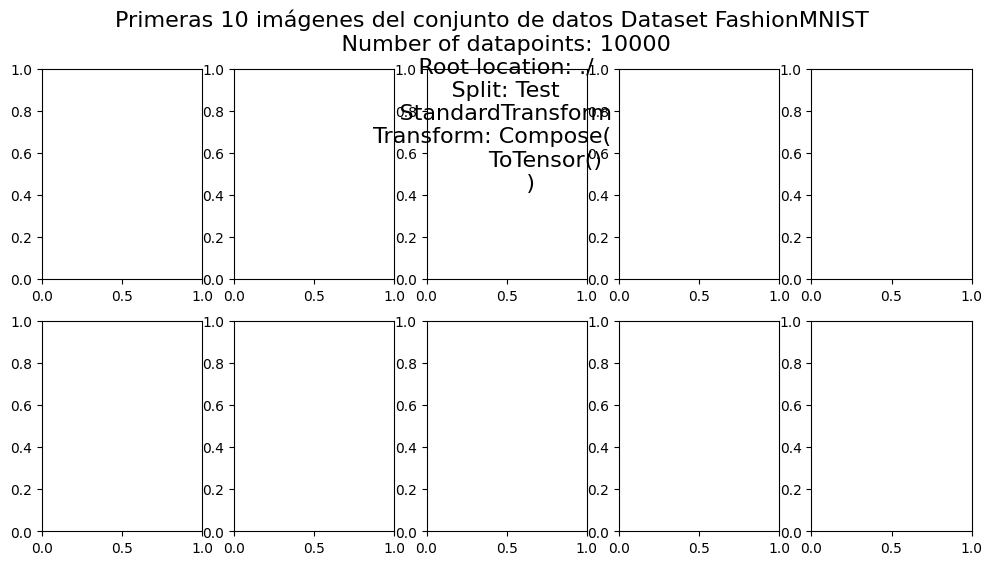

In [ ]:
#Evaluamos en el conjunto de testeo (seguramente se hará en la parte c o d)
test_dl = DataLoader(fashionmnist_test_dataset, batch_size, shuffle=True)

modela.eval()  # No entrenamos
predictions = []  # Almacena las predicciones del modelo
true_labels = []  # Almacena las etiquetas reales

with torch.no_grad():
    for instancia, etiqueta in test_dl:
        outputs = modela(instancia)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(etiqueta.tolist())

#Calculamos entropía
loss_fn = nn.CrossEntropyLoss()
entropies = []

for i in range(min(len(true_labels), len(outputs))):
    loss = loss_fn(outputs[i].unsqueeze(0), torch.tensor([true_labels[i]]))
    entropy = -1 * torch.log(torch.exp(-loss))
    entropies.append(entropy.item())

#Tomamos las 10 más altas
top_difficult_instances = sorted(range(len(entropies)), key=lambda i: entropies[i], reverse=True)[:10]

# Imprimir las 10 instancias más difíciles y sus etiquetas
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(f"Primeras 10 imágenes del conjunto de datos {fashionmnist_test_dataset}", fontsize=16)
for index in top_difficult_instances:
    image, label = fashionmnist_test_dataset[index]  # Obten la imagen y etiqueta correspondientes
    print(f"Etiqueta real: {label}")
    ax = axes[index // 5, index % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Clase: {label}')
    ax.axis('off')
plt.show()


In [ ]:
print(top_difficult_instances)

In [ ]:
# Se crea el modelo
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
layer = nn.Linear(input_size, 32)
all_layers.append(layer)
# all_layers.append(nn.Sigmoid())
# layer = nn.Linear(32, 32)
# all_layers.append(layer)
# all_layers.append(nn.Tanh())
# layer = nn.Linear(32, 32)
# all_layers.append(layer)
all_layers.append(nn.ReLU())
layer = nn.Linear(32, 32)
all_layers.append(layer)
all_layers.append(nn.LogSoftmax(dim=1))

all_layers.append(nn.Linear(32,cantidad_categorias))

model = nn.Sequential(*all_layers)

print(model)

#####Entrenamiento



In [ ]:
# Realizamos el entrenamiento del modelo base
tasa_aprendizaje = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=tasa_aprendizaje)
num_epochs = 10
model, lista_perdida, lista_accuracy = train(model, num_epochs, optimizer)

#####Evaluación

In [ ]:
graficar_evolucion_perdida_acurracy(lista_perdida, lista_accuracy)

####Arquitectura 2

#####Definición y entrenamiento

In [ ]:
# Se crea el modelo
hidden_units = 32

# Nuestro primer paso es convertir las imágenes a un vector
all_layers = [nn.Flatten()]

# Creamos la capa oculta
layer = nn.Linear(input_size, hidden_units)
all_layers.append(layer)

# Agregamos la función de activación sigmoide
all_layers.append(nn.Sigmoid())

# Agregamos la capa de salida
all_layers.append(nn.Linear(hidden_units,cantidad_categorias))

# Construimos el modelo
model = nn.Sequential(*all_layers)

print(model)

#####Evaluación

####Arquitectura 3

#####Definición y entrenamiento

In [ ]:
# Se crea el modelo
hidden_units = 32

# Nuestro primer paso es convertir las imágenes a un vector
all_layers = [nn.Flatten()]

# Creamos la capa oculta
layer = nn.Linear(input_size, hidden_units)
all_layers.append(layer)

# Agregamos la función de activación sigmoide
all_layers.append(nn.Sigmoid())

# Agregamos la capa de salida
all_layers.append(nn.Linear(hidden_units,cantidad_categorias))

# Construimos el modelo
model = nn.Sequential(*all_layers)

print(model)

#####Evaluación

###c) A partir del mejor modelo obtenido en b), sugiera y aplique algún mecanimo de regularización y vuelva a evaluar sobre el conjunto de validación, igual que en el paso anterior.

###d) Con el mejor modelo obtenido luego de los pasos anteriores, evalúe su performance sobre el conjunto de evaluación utilizando accuracy, precision, recall y medida F1 para cada una de las clases. Construya la matriz de confusión. Comente los resultados y compare con los reportados en el sitio del dataset.

####Función para generar matriz de confusión

In [ ]:
def mostrar_matriz_confusion(matriz_confusion):

  # Calcula los porcentajes dividiendo cada valor en la matriz de confusión por el total de la fila correspondiente
  matriz_confusion_porcentaje = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]

  plt.imshow(matriz_confusion_porcentaje, cmap='Purples')

  # Configura el formato de los valores de la matriz como porcentajes
  fmt = '.2f'
  thresh = matriz_confusion_porcentaje.max() / 2.
  for i in range(matriz_confusion_porcentaje.shape[0]):
    for j in range(matriz_confusion_porcentaje.shape[1]):
        plt.text(j, i, format(matriz_confusion_porcentaje[i, j], fmt), ha="center", va="center", color="white" if matriz_confusion_porcentaje[i, j] > thresh else "black")

  # Etiquetas
  etiquetas = range(10)

  # Establece los ticks personalizados y las etiquetas para los ejes x e y
  plt.xticks(np.arange(len(etiquetas)), etiquetas)
  plt.yticks(np.arange(len(etiquetas)), etiquetas)


  plt.title('Matriz de Confusión')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')

  plt.colorbar()
  plt.show()

#### Evaluación con el conjunto de testeo

In [ ]:
 # Predecimos utilizando el modelo

# Antes normalizamos los valores RGB
# Esto lo hago porque no paso por el transform
predicciones = model(mnist_test_dataset.data/255.)
predicciones = torch.argmax(predicciones,dim=1).numpy()

valores_reales = mnist_test_dataset.targets.numpy()

print(metrics.classification_report(valores_reales, predicciones))
mostrar_matriz_confusion(metrics.confusion_matrix(valores_reales, predicciones))

### e) Muestre las diez instancias del conjunto de evaluación más “difíciles” para el clasificador construido, utilizando como medida la entropía. Comente los resultados.